# CycleGAN

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples. 

This notebook assumes you are familiar with Pix2Pix, which you can learn about in the [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. 

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

![Output Image 1](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_1.png?raw=1)
![Output Image 2](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_2.png?raw=1)

## Set up the input pipeline


## **Mount Google Drive**

## **Preprocessing + Data Augmentation**

In [ ]:
print(tf. __version__) 

2.7.0


In [8]:
!pip install colab_ssh --upgrade
from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password="connect")

In [ ]:
# load images
filepath = 'drive/My Drive/cycleGAN/data/EOS'
files = os.listdir(filepath)

# define target image size

input_height = 256
input_width = 256
scaling_factor = 1
# calculate target image size
target_height = int(input_height)
target_width = int(input_width)
target_channel = 3;
length = len(files)

# create empty arrays for images
XRay_fr = np.empty((length, target_height, target_width, target_channel))
XRay_sag = np.empty((length, target_height, target_width, target_channel))
filenames = np.empty((length))

for k in range(length):
    filenames[k] = print(files[k])
    data = sio.loadmat(os.path.join(filepath, files[k]))
    image_fr = np.empty((target_height, target_width, target_channel))
    image_fr[:,:,0] = data['im_fr_resized']
    image_fr[:,:,1] = data['im_fr_resized']
    image_fr[:,:,2] = data['im_fr_resized']

    image_sag = np.empty((target_height, target_width, target_channel))
    image_sag[:,:,0] = data['im_sag_resized']
    image_sag[:,:,1] = data['im_sag_resized']
    image_sag[:,:,2] = data['im_sag_resized']

    #image_sag = data['im_sag_resized'].reshape(target_height, target_width)

    XRay_fr[k]  = image_fr #cv2.resize(image, (target_width, target_height), interpolation = cv2.INTER_AREA)
    XRay_sag[k]  = image_sag

    print(k)

In [ ]:
print(XRay_fr.shape)
print(XRay_sag.shape)

(496, 256, 256, 3)
(496, 256, 256, 3)


In [ ]:
XRay_fr = tf.cast(XRay_fr, dtype='float32')
XRay_sag = tf.cast(XRay_sag, dtype='float32')

XRay_fr_dataset = tf.data.Dataset.from_tensor_slices((XRay_fr))
XRay_sag_dataset = tf.data.Dataset.from_tensor_slices((XRay_sag))

In [ ]:
print(XRay_fr_dataset)
print(XRay_sag_dataset)


<TensorSliceDataset shapes: (256, 256, 3), types: tf.float32>
<TensorSliceDataset shapes: (256, 256, 3), types: tf.float32>


In [ ]:
# load DRR images
folder_path = 'drive/My Drive/cycleGAN/data/DRR'
files = os.listdir(folder_path)

length = len(files)

# create empty arrays for images
DRR = np.empty((length, target_height, target_width, target_channel))

for k in range(length):
    #print(files[k])
    data = sio.loadmat(os.path.join(folder_path, files[k]))
    image = np.empty((target_height, target_width, target_channel))
    image[:,:,0] = data['im_resized']
    image[:,:,1] = data['im_resized']
    image[:,:,2] = data['im_resized']
    #image = data['im_resized'].reshape(target_height, target_width, target_channel)
    #print(image)
    image = tf.convert_to_tensor(image)
    DRR[k]  = image

    print(k)

In [ ]:
DRR = tf.cast(DRR, dtype='float32')

DRR_dataset = tf.data.Dataset.from_tensor_slices((DRR))
print(DRR_dataset)

<TensorSliceDataset shapes: (256, 256, 3), types: tf.float32>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


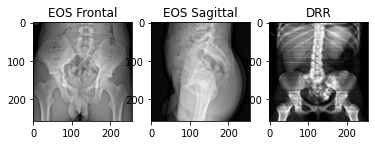

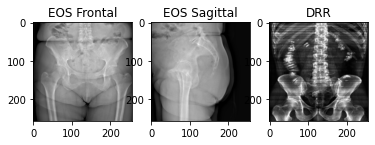

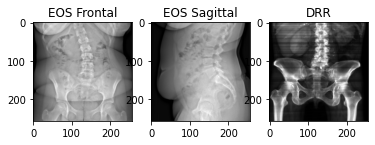

In [ ]:
for i in range(3):
  fig = plt.figure()
  plt.subplot(1, 3, 1)
  plt.imshow(XRay_fr[i],cmap='gray')
  plt.title('EOS Frontal')
  plt.subplot(1,3, 2)
  plt.imshow(XRay_sag[i], cmap='gray')
  plt.title('EOS Sagittal')
  plt.subplot(1, 3, 3)
  plt.imshow(DRR[i], cmap='gray')
  plt.title('DRR')

plt.show()

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image): #, label):
  image = random_jitter(image)
  return image

In [ ]:
XRay_fr = XRay_fr_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

XRay_sag = XRay_sag_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

DRR = DRR_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
tf.executing_eagerly()


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


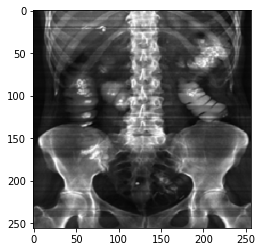

In [ ]:
sample_DRR = iter(DRR)
sample_DRR = next(sample_DRR)
plt.imshow(sample_DRR[0])

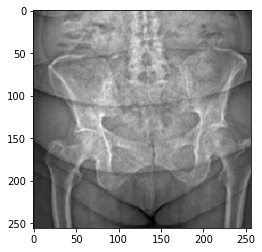

In [ ]:
iter(XRay_fr)
sample_XRay_fr = iter(XRay_fr)
sample_XRay_fr = next(sample_XRay_fr)
plt.imshow(sample_XRay_fr[0])

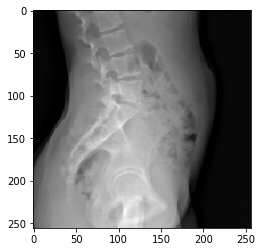

In [ ]:
iter(XRay_sag)
sample_XRay_sag = iter(XRay_sag)
sample_XRay_sag = next(sample_XRay_sag)
plt.imshow(sample_XRay_sag[0])

In [ ]:
sample_XRay_sag[0].shape

TensorShape([256, 256, 3])

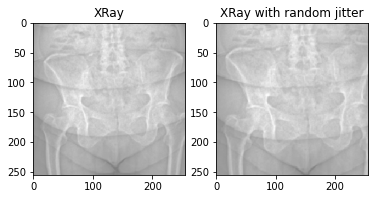

In [ ]:
plt.subplot(121)
plt.title('XRay')
plt.imshow(sample_XRay_fr[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('XRay with random jitter')
plt.imshow(random_jitter(sample_XRay_fr[0]) * 0.5 + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


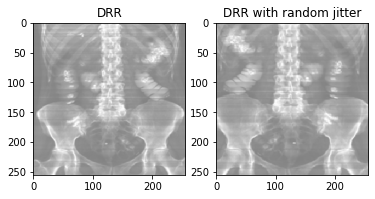

In [ ]:
plt.subplot(121)
plt.title('DRR')
plt.imshow(sample_DRR[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('DRR with random jitter')
plt.imshow(random_jitter(sample_DRR[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

#Change Pix2Pix Code for BW IMAGE

In [ ]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [ ]:
def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 1], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

#Execute PIX2PIX

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
checkpoint_path = "drive/My Drive/cycleGAN/checkpoint"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Script to avoid disconecting

In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [ ]:
import tensorflow as tf 
tf.compat.v1.enable_eager_execution()
tf.test.gpu_device_name()

!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-4716c50a-0e1f-3d21-dea3-f5cd397e3b77)


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-xr8_kej6
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-xr8_kej6
  Created wheel for tensorflow-examples: filename=tensorflow_examples-2d6df0e2691ab68be61530dcb25e9aa288711689_-py3-none-any.whl size=268413 sha256=d094dcc80504133ac41bd3363d44310abc56c9752125b0825dd754be374901e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-goo6rvt3/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import scipy.io as sio
import cv2
import random
from IPython.display import clear_output
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
sample_DRR

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


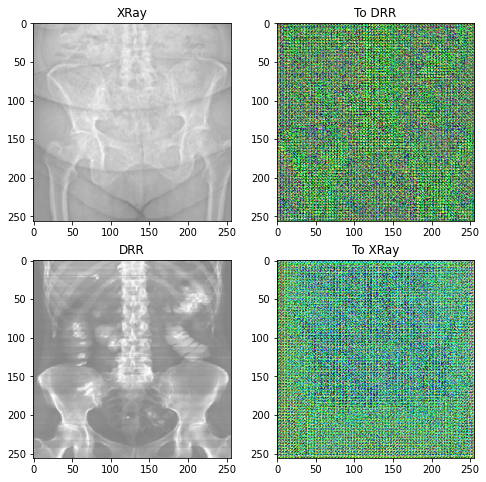

In [ ]:
to_DRR = generator_g(sample_DRR)
to_XRay_fr = generator_f(sample_XRay_fr)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_XRay_fr, to_DRR, sample_DRR, to_XRay_fr]
title = ['XRay', 'To DRR', 'DRR', 'To XRay']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

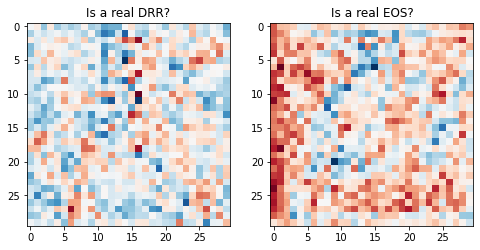

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real DRR?')
plt.imshow(discriminator_y(sample_DRR)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real EOS?')
plt.imshow(discriminator_x(sample_XRay_fr)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']
  

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  return prediction[0]

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
DRR

<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>

In [ ]:
export_path = 'drive/My Drive/cycleGAN/checkpoint/predictions/'

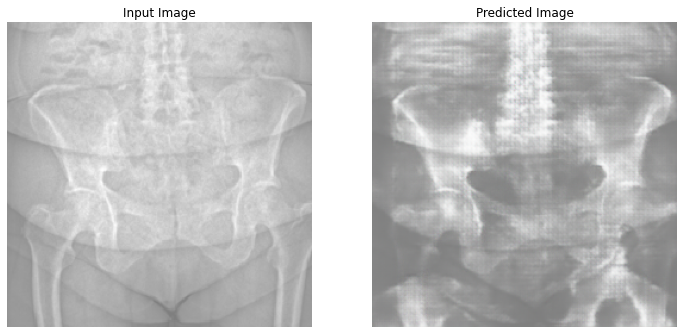

Time taken for epoch 32 is 133.22723054885864 sec

................

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((XRay_fr, DRR)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_XRay_fr) so that the progress of the model
  # is clearly visible.
  prediction = generate_images(generator_g, sample_XRay_fr)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    fig_name = os.path.join(export_path, 'predicted_img_{epoch}.png'.format(epoch=epoch))
    plt.imshow(prediction)
    plt.savefig(fig_name)

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
export_path = 'drive/My Drive/cycleGAN/weights/generator_g'
generator_g.save(export_path, 'generator_g_05122021.h5')
generator_g.save_weights(export_path)

export_path = 'drive/My Drive/cycleGAN/weights/generator_f/'
generator_f.save(export_path, 'generator_f_05122021.h5')
generator_f.save_weights(export_path)

INFO:tensorflow:Assets written to: drive/My Drive/cycleGAN/weights/assets
INFO:tensorflow:Assets written to: drive/My Drive/cycleGAN/weights/assets


In [ ]:
while True:pass

## Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.